# gpt2_basic_training_small
## 2026JAN30

Does basic pretraining of a gpt2-small model with a short story (the-verdict.txt), shows reproducibility of results, and tests whether results were specific to the-verdict text by comparing to a different short story.  


# 0. DETECTION OF GOOGLE DRIVE AND SETUP PATHS  
Some basics for detection of whether using google drive and colaboratory.  
Strong recommend to do this - very easy setup and much faster operation using a GPU (T4 GPU as of January 2026). See README.md for installation instructions.

Inspect the various path variables (PROJECT_ROOT, DATA_DIR, OUTPUT_DIR, SRC_DIR) if there are problems.

In [1]:
# CELL 1: Optional Google Drive mount (Colab only)
import os
from pathlib import Path

def in_colab() -> bool:
    return "COLAB_GPU" in os.environ or "COLAB_TPU_ADDR" in os.environ or "google.colab" in str(getattr(__import__("sys"), "modules", {}))

IN_COLAB = in_colab()

if IN_COLAB:
    try:
        from google.colab import drive  # type: ignore
        drive.mount("/content/drive")
        print("Mounted Google Drive at /content/drive")
    except Exception as e:
        print(f"Could not mount Google Drive: {e}")
else:
    print("Not running in Colab; skipping Drive mount.")


Mounted at /content/drive
Mounted Google Drive at /content/drive


In [2]:

# CELL 2: Resolve PROJECT_ROOT (env override > Colab Drive default > search from cwd)
import os
import sys
from pathlib import Path

env_root = os.environ.get("LLM_PROJECT_ROOT", "").strip()
default_colab_root = Path("/content/drive/MyDrive/llm-from-scratch-drive")

def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "src").exists():
            return p
    return start

if env_root:
    PROJECT_ROOT = Path(env_root).expanduser().resolve()
elif default_colab_root.exists():
    PROJECT_ROOT = default_colab_root.resolve()
else:
    PROJECT_ROOT = find_repo_root(Path.cwd().resolve())

print("CWD:", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC exists:", (PROJECT_ROOT / "src").exists())


CWD: /content
PROJECT_ROOT: /content/drive/MyDrive/llm-from-scratch-drive
SRC exists: True


## 1. package loading

In [3]:
# CELL 3: Imports
import json
from copy import deepcopy
from datetime import datetime

import torch
import torch.nn as nn
import tiktoken
import pickle

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.utils.data import Dataset, DataLoader



## 2. setup paths for llm package load

In [4]:

# CELL 4: Paths + sys.path + project imports
SRC_DIR = PROJECT_ROOT / "src"
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "output"

# Create output dir if missing (safe)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("SRC_DIR:", SRC_DIR)
print("DATA_DIR:", DATA_DIR)
print("OUTPUT_DIR:", OUTPUT_DIR)

# Add src to import path (notebook-friendly)
if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# Now your imports work locally or in Colab
from llm_from_scratch.configs import gpt2small_config
from llm_from_scratch.training import training_utils
from llm_from_scratch.models import gpt2
from llm_from_scratch.dataloader import dataloader


SRC_DIR: /content/drive/MyDrive/llm-from-scratch-drive/src
DATA_DIR: /content/drive/MyDrive/llm-from-scratch-drive/data
OUTPUT_DIR: /content/drive/MyDrive/llm-from-scratch-drive/output


## 3. setup run_training()

In [5]:
def run_training(cfg):
    """Run a single training experiment given a config dict."""

    # timing
    start = datetime.now()

    # debug_flag
    debug_flag = True # True means that a lot of extra info is output

    cfg = deepcopy(cfg)  # avoid in-place mutation
    model_cfg = cfg['model_config']

    # adjust device if cuda not available and cuda was chosen
    device = cfg['device_name']
    print("DEVICE: initial device before adjustment:",device)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("DEVICE: device AFTER adjustment:",str(device))
    cfg['device_name'] = str(device)

    torch.manual_seed(cfg['seed'])



    print(cfg)

    model = gpt2.setup_model(model_cfg)
    model.to(device)
    totparams = sum(p.numel() for p in model.parameters())
    print("Total number of parameters:", totparams)

    # DEBUG: check model and weight_tying
    if debug_flag:
      print("weight_tying flag:", model_cfg["weight_tying"])
      print("same object?:", model.out_head.weight is model.tok_emb.weight)
      print("out_head.weight shape:", model.out_head.weight.shape)
      print("tok_emb.weight shape:", model.tok_emb.weight.shape)

     # tokenizer
    tokenizer = tiktoken.get_encoding(cfg['tokenizer'])

    # if want pretrained params, here is pickle code
    # LOAD FROM PICKLE FILES - MB alteration
    # here is for GPT2-small
    if cfg['load_pretrained_params']:
      # set params file
      cfg['params_file']=str(DATA_DIR) + "/gpt2_openai_params_124M.pkl"

      # Load params
      fullnm = cfg['params_file']
      with open(fullnm, "rb") as f:
          params = pickle.load(f)
      if debug_flag:
        print(params.keys())
        print(params['wpe'].shape)
      training_utils.load_weights_into_gpt(model, params)
      model.to(device)
      # show pretrain example
      print("pretrain example:")
      training_utils.generate_and_print_sample(model,cfg, tokenizer, device, cfg['start_context'])

    # dataloaders
    train_loader, val_loader, test_loader = dataloader.generate_data_loaders(cfg)
    print("Show train_loader first entry (converted to text):")
    dataloader.loader_text_examine(train_loader, 0, tokenizer)
    print("Show val_loader first entry (converted to text):")
    dataloader.loader_text_examine(val_loader, 0, tokenizer)
    if test_loader is not None:
        print("Show test_loader first entry (converted to text):")
        dataloader.loader_text_examine(test_loader, 0, tokenizer)

    # evaluation before running code
    print("BEFORE TRAINING:")
    before_res = training_utils.eval_full_sets(model, train_loader, val_loader, device, do_train=True)

    # training loop
    model.train()
    num_epochs = cfg['num_epochs']
    optimizer = training_utils.setup_optimizer(model, cfg)
    train_losses, val_losses, tokens_seen, global_step = training_utils.train_model_simple(
        model=model,
        cfg=cfg,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=cfg['device_name'],
        num_epochs=cfg['num_epochs'],
        eval_freq=cfg['eval_freq'],
        eval_iter=cfg['eval_iter'],
        save_freq=cfg['save_freq'],
        start_context=cfg['start_context'],
        tokenizer=tokenizer
    )

    # plot and save plot
    epochs_tensor = torch.linspace(0, cfg['num_epochs'], len(train_losses))
    training_utils.plot_losses(cfg, epochs_tensor, tokens_seen, train_losses, val_losses)

    # save cfg and checkpoint
    training_utils.save_cfg_json(
        cfg=cfg,
        epoch=num_epochs,
        global_step=global_step)

    training_utils.save_results(cfg,
        train_losses, val_losses, tokens_seen, global_step)

    # evaluation after training
    print("AFTER TRAINING:")
    after_res = training_utils.eval_full_sets(model, train_loader, val_loader, device, do_train=True)

    # timing at end
    end = datetime.now()
    elapsed = end - start

    total_seconds = int(elapsed.total_seconds())
    hours, rem = divmod(total_seconds, 3600)
    minutes, seconds = divmod(rem, 60)
    runtime_formatted = f"{hours:02d}:{minutes:02d}:{seconds:02d}"
    print(f"Runtime: {runtime_formatted}")

    resdict = {
        "initial_train_loss_full_set": float(before_res[0]),
        "initial_val_loss_full_set": float(before_res[1]),
        "final_train_loss_full_set": float(after_res[0]),
        "final_val_loss_full_set": float(after_res[1]),
        "tokens_seen": int(tokens_seen[-1]),
        "global_step": int(global_step),
        "runtime": runtime_formatted
    }
    print(resdict)

    # return model
    return model



## 4. EXPERIMENT: train model with basic params using the-verdict.txt short story  
Notes:  
1. Last 10% of story taken as validation set (adjustable parameter)  
2. There are currently fairly voluminous outputs  


### config  

In [6]:
cfg = gpt2small_config.RUN_CONFIG
cfg
cfg2 = deepcopy(cfg)

# setup for load of OpenAI weights, and prepare for continued pre-training
cfg2['run_name'] = "gpt2_theverdict_pretrain_small"
cfg2['description'] = "gpt2 type model with training on a the-verdict story"
cfg2['load_pretrained_params']=False

# epochs and batch_size, and stride
cfg2['num_epochs']=6 # just to check things
cfg2['batch_size']=2

# evaluation cycle params
cfg2['eval_freq']=5
cfg2['eval_iter']=5

# device and saving
cfg2['device_name'] = "cuda" # will run decently on cpu, just relatively slow
cfg2['save_overwrite']= True # if True, save the checkpoint with simple name and overwrite previous one

# set training file t
cfg2['training_file'] = str(DATA_DIR) + "/the-verdict.txt"
print(cfg2['training_file'])

# set output directory
cfg2['output_dir'] = str(OUTPUT_DIR)
print(cfg2['output_dir'])

print(cfg2)


/content/drive/MyDrive/llm-from-scratch-drive/data/the-verdict.txt
/content/drive/MyDrive/llm-from-scratch-drive/output
{'run_name': 'gpt2_theverdict_pretrain_small', 'description': 'gpt2 type model with training on a the-verdict story', 'device_name': 'cuda', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'load_pretrained_params': False, 'params_file': '/home/markb/llm-from-scratch/data/gpt2_params.pkl', 'training_file': '/content/drive/MyDrive/llm-from-scratch-drive/data/the-verdict.txt', 'start_context': 'Every effort moves you', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 256, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 6, 'seed': 123, 'eval_freq': 5, 'eval_iter': 5, 'save_freq': 200, 'output_dir': '/content/drive/MyDrive/llm-from-scratch-drive/output', 'sa

### run model

DEVICE: initial device before adjustment: cuda
DEVICE: device AFTER adjustment: cuda
{'run_name': 'gpt2_theverdict_pretrain_small', 'description': 'gpt2 type model with training on a the-verdict story', 'device_name': 'cuda', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'load_pretrained_params': False, 'params_file': '/home/markb/llm-from-scratch/data/gpt2_params.pkl', 'training_file': '/content/drive/MyDrive/llm-from-scratch-drive/data/the-verdict.txt', 'start_context': 'Every effort moves you', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 256, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 6, 'seed': 123, 'eval_freq': 5, 'eval_iter': 5, 'save_freq': 200, 'output_dir': '/content/drive/MyDrive/llm-from-scratch-drive/output', 'save_overwrite': True}
Total number o

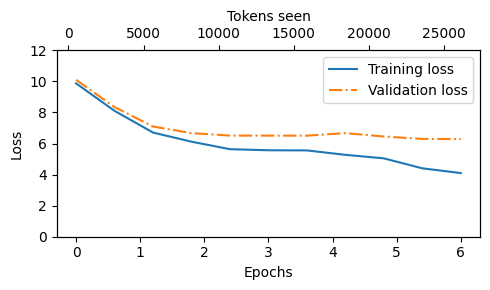

Saved cfg to /content/drive/MyDrive/llm-from-scratch-drive/output/gpt2_theverdict_pretrain_small/epoch006_step0000053_cfg.json
Saved results to /content/drive/MyDrive/llm-from-scratch-drive/output/gpt2_theverdict_pretrain_small/epoch006_step0000053_results.json
AFTER TRAINING:
FULL train loss: 3.745796733432346
FULL val loss: 6.211734771728516
Runtime: 00:00:51
{'initial_train_loss_full_set': 10.98758347829183, 'initial_val_loss_full_set': 10.98110580444336, 'final_train_loss_full_set': 3.745796733432346, 'final_val_loss_full_set': 6.211734771728516, 'tokens_seen': 26112, 'global_step': 53, 'runtime': '00:00:51'}


In [7]:
model_after = run_training(cfg2)

## Experiment 1a: Do we have reproducibility - can we get identical results by rerunning the training?
Idea is that behavior should be identical - no lingering states  



DEVICE: initial device before adjustment: cuda
DEVICE: device AFTER adjustment: cuda
{'run_name': 'gpt2_theverdict_pretrain_small_run2', 'description': 'gpt2 type model with training on a the-verdict story', 'device_name': 'cuda', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'load_pretrained_params': False, 'params_file': '/home/markb/llm-from-scratch/data/gpt2_params.pkl', 'training_file': '/content/drive/MyDrive/llm-from-scratch-drive/data/the-verdict.txt', 'start_context': 'Every effort moves you', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 256, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 6, 'seed': 123, 'eval_freq': 5, 'eval_iter': 5, 'save_freq': 200, 'output_dir': '/content/drive/MyDrive/llm-from-scratch-drive/output', 'save_overwrite': True}
Total num

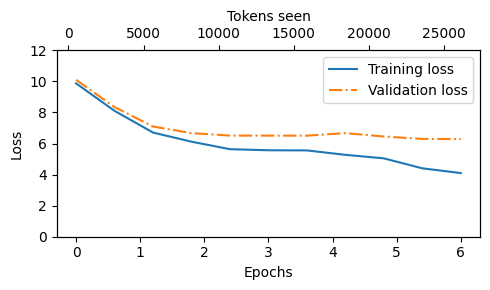

Saved cfg to /content/drive/MyDrive/llm-from-scratch-drive/output/gpt2_theverdict_pretrain_small_run2/epoch006_step0000053_cfg.json
Saved results to /content/drive/MyDrive/llm-from-scratch-drive/output/gpt2_theverdict_pretrain_small_run2/epoch006_step0000053_results.json
AFTER TRAINING:
FULL train loss: 3.745796733432346
FULL val loss: 6.211734771728516
Runtime: 00:00:40
{'initial_train_loss_full_set': 10.98758347829183, 'initial_val_loss_full_set': 10.98110580444336, 'final_train_loss_full_set': 3.745796733432346, 'final_val_loss_full_set': 6.211734771728516, 'tokens_seen': 26112, 'global_step': 53, 'runtime': '00:00:40'}


In [8]:
cfg2['run_name']="gpt2_theverdict_pretrain_small_run2"
model_after_run2=run_training(cfg2)

## Experiment 2: Do we see similar training dynamics with a different text from the same type (short story)?
There are two rationales for this, one for this current work and one looking forward.
1. For this current work, it is interesting to see if different corpora perform significantly differently. Both are open source short stories (or part of a short story, truncated to be similar length to the first, for the second). This is just a basic check to see if reasonably similar sources vary much. Note also the concern that the test set is simply the last part of each story; this could easily have different characteristics than the rest of the text. Visual inspection doesn't reveal anything crazy (like if the last part were an author's note with different words and style than earlier) - but this could obviously be quantified by looking at word frequency or ngram frequency, etc. Simply comparing loss curves (both training and validation) for these two stories allows a quick and dirty examination of the effect of source material, when the source material is similar.

2. Longer run: rationale for this is that there is a concern that "the-verdict" text may have been part of the training set of GPT2. I found an "open source" text that is from ~2024/2025, so should not have been part of the ~2019 training of GPT2. This is not an issue here with training from scratch, but for continued pre-training and evaluation, it is. So the test here is to see if this alterate text performs similarly, so I can use it with continued pre-training experiments in the GPT2-small framework.  

OTHER POINTS  

3. I expect minor some minor differences; these texts are sylistically quite different in many ways, which can affect training.

4. How could there be issues with using the last x% in real life? Well, even for a story, there may be a large change in word choice and tone at the end of a story - maybe an unseen narrator kicks in to explain some things or something like that. If there is this change from early in the story to late in the story, then our training set and validation set would not be a good match.  



DEVICE: initial device before adjustment: cuda
DEVICE: device AFTER adjustment: cuda
{'run_name': 'gpt2_alterate_story', 'description': 'gpt2 with the adjusted watch story', 'device_name': 'cuda', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'load_pretrained_params': False, 'params_file': '/home/markb/llm-from-scratch/data/gpt2_params.pkl', 'training_file': '/content/drive/MyDrive/llm-from-scratch-drive/data/The-watch-story-adj-smaller-2.txt', 'start_context': 'Every effort moves you', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 256, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 6, 'seed': 123, 'eval_freq': 5, 'eval_iter': 5, 'save_freq': 200, 'output_dir': '/content/drive/MyDrive/llm-from-scratch-drive/output', 'save_overwrite': True}
Total number of parameter

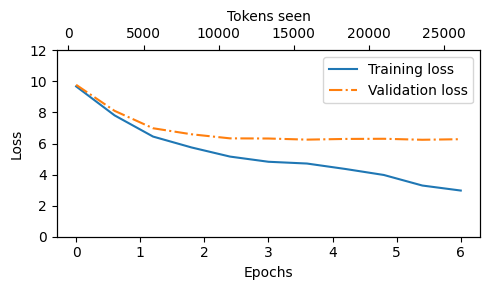

Saved cfg to /content/drive/MyDrive/llm-from-scratch-drive/output/gpt2_alterate_story/epoch006_step0000053_cfg.json
Saved results to /content/drive/MyDrive/llm-from-scratch-drive/output/gpt2_alterate_story/epoch006_step0000053_results.json
AFTER TRAINING:
FULL train loss: 2.654033448961046
FULL val loss: 6.2968974113464355
Runtime: 00:00:47
{'initial_train_loss_full_set': 10.955245123969185, 'initial_val_loss_full_set': 10.981555938720703, 'final_train_loss_full_set': 2.654033448961046, 'final_val_loss_full_set': 6.2968974113464355, 'tokens_seen': 26112, 'global_step': 53, 'runtime': '00:00:47'}


In [9]:
cfg2['run_name']="gpt2_alterate_story"
cfg2['description']="gpt2 with the adjusted watch story"
cfg2['training_file'] = str(DATA_DIR) +  "/The-watch-story-adj-smaller-2.txt"
model_story2 = run_training(cfg2)

### RESULTS  
1. Curves are quite similar with the two texts.  
2. With identical number of tokens seen, have somewhat smaller training loss with the watch vs the verdict and very slightly higher validation loss.  
3. Implications:  
    a. these texts do not appear to be some crazy texts that would mess with interpretation in these simple basic frameworks.  
    b. these texts can both be used later on for looking at the pre-trained models. The first text may have been part of the training set for the GPT2-small, but the second text is well after the training cutoff, so almost certainly was not.